In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from Finite_volume_method_1D import *

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 200,
})

In [2]:
datapath = '../../DataKian/Al_LT165chip7/673nm/'
# datapath = '../../DataKian/bTa_LT278W2chip5/673nm/'
data = np.genfromtxt(datapath+'KID2_89dBm__TmK120_avgpulse_ampphase.csv',skip_header=1,delimiter=',')

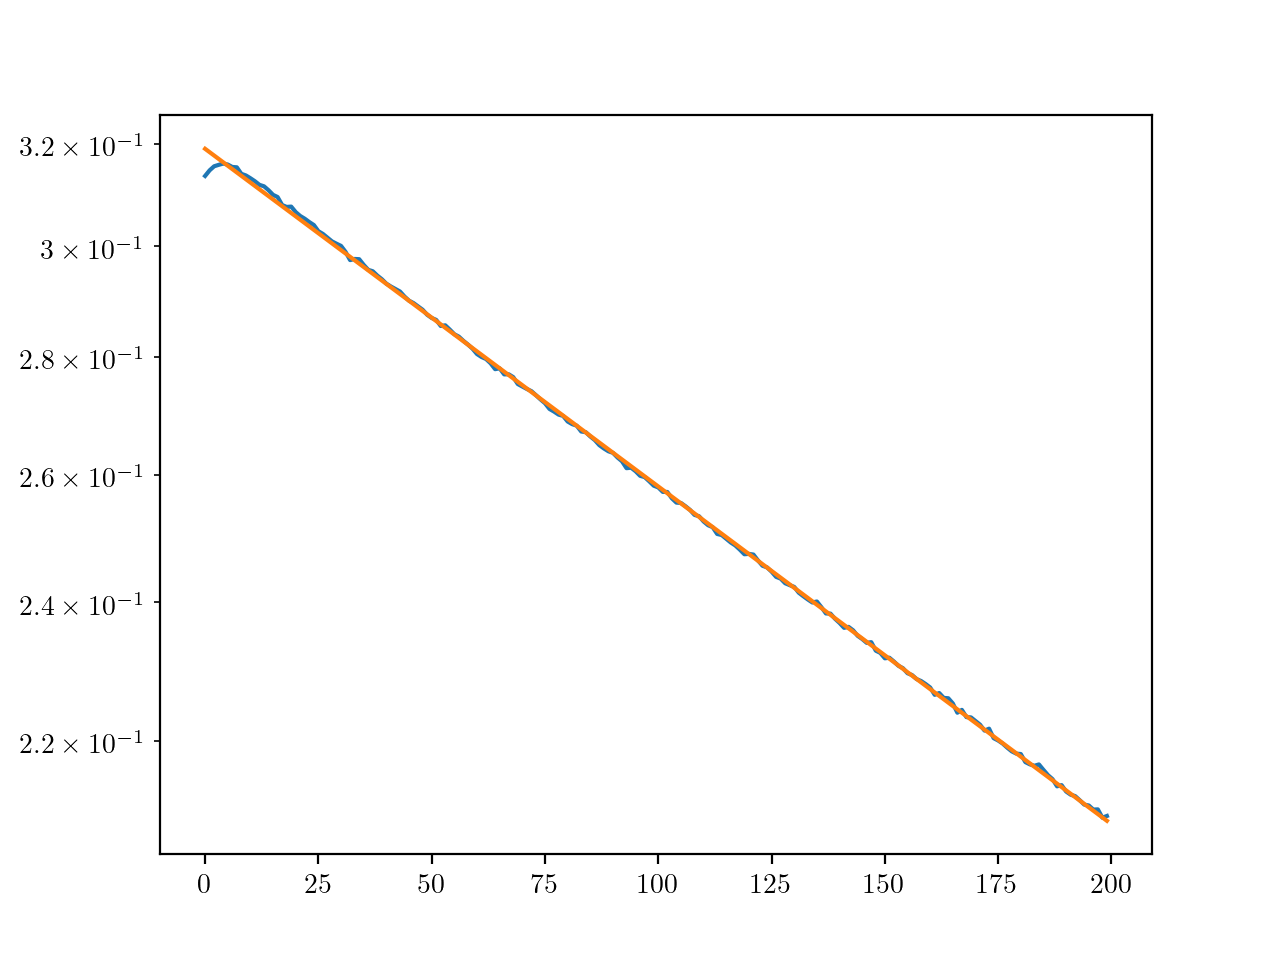

In [3]:
# Shift to align data, select phase
phase = data[508:,2] # 100: for bTa, 500: for Al

# Cut off the noisy part
ref = phase[0]
for i in range(len(phase))[::50]:
    if ref - phase[i] < 0:
        print(i)
        phase = phase[:i]
        break
    ref = phase[i]
# Cut off after 200us
phase = phase[:200]

t_range = np.arange(len(phase)) # in us

pars, cov = np.polyfit(t_range,np.log(phase),1,cov=True)
a = np.exp(pars[1])
b = pars[0]
b_std = np.sqrt(np.diag(cov)[0])
tau = -1/b # = tau_qp^*
tau_std = b_std/b**2

plt.figure()
plt.semilogy(phase)
plt.semilogy(a*np.exp(-t_range/tau))

In [4]:
# Parameters Al, photon@673nm

lambda_ph = 0.673 #um
h= 4.1356e-9 #eV us
c = 299792458 #um/us
k_B = 0.00008617343 # eV/K
eta_pb = 0.59 # 0.59 maximum
E_ph = h*c/lambda_ph
T_c = 1.11
Delta = 1.764*k_B*T_c
N_init = eta_pb*E_ph/Delta
tau_qp_star = tau
width = 10 #um
height = 0.04 #um
length = 310 #um
T_eff = 0.22 #K
N0 = 17200000000 # /eV /um^3

Q0=2*N0*np.sqrt(2*np.pi*k_B*T_eff*Delta)*np.exp(-Delta/(k_B*T_eff))*width*height
R=1/(2*tau_qp_star*Q0)
D_all=15000
sigma_init=10

# specific to KID and Temp, put everything us and 
dthetadN = 4.974e-5
Q= 4.312e4
f0 = 4.313e9 * 1000 # /us

In [5]:
# define simulation geometry
dt=0.125
dx=1.125
L=length # make sure dx cleanly divides L
N=int(L/dx)
x_borders=np.linspace(-L/2,L/2,N,endpoint=True)
x_centers=np.linspace(-L/2+dx,L/2-dx,N-1,endpoint=True)
D=np.ones_like(x_borders)*D_all

# IC
Q_init = np.exp(-0.5*(x_centers/sigma_init)**2)*N_init/(sigma_init*np.sqrt(2*np.pi))

print(N_init)
print(np.trapz(Q_init,x_centers))

# Simulation
T=len(phase)
times, Q_list_Al = simulate(Q_init,int(T/dt),dt,dx,D_all,R,Q0)

6441.711013546319
6441.711013546319


100%|██████████| 1600/1600 [01:35<00:00, 16.76it/s]


eta_pb =  0.5818836136824592


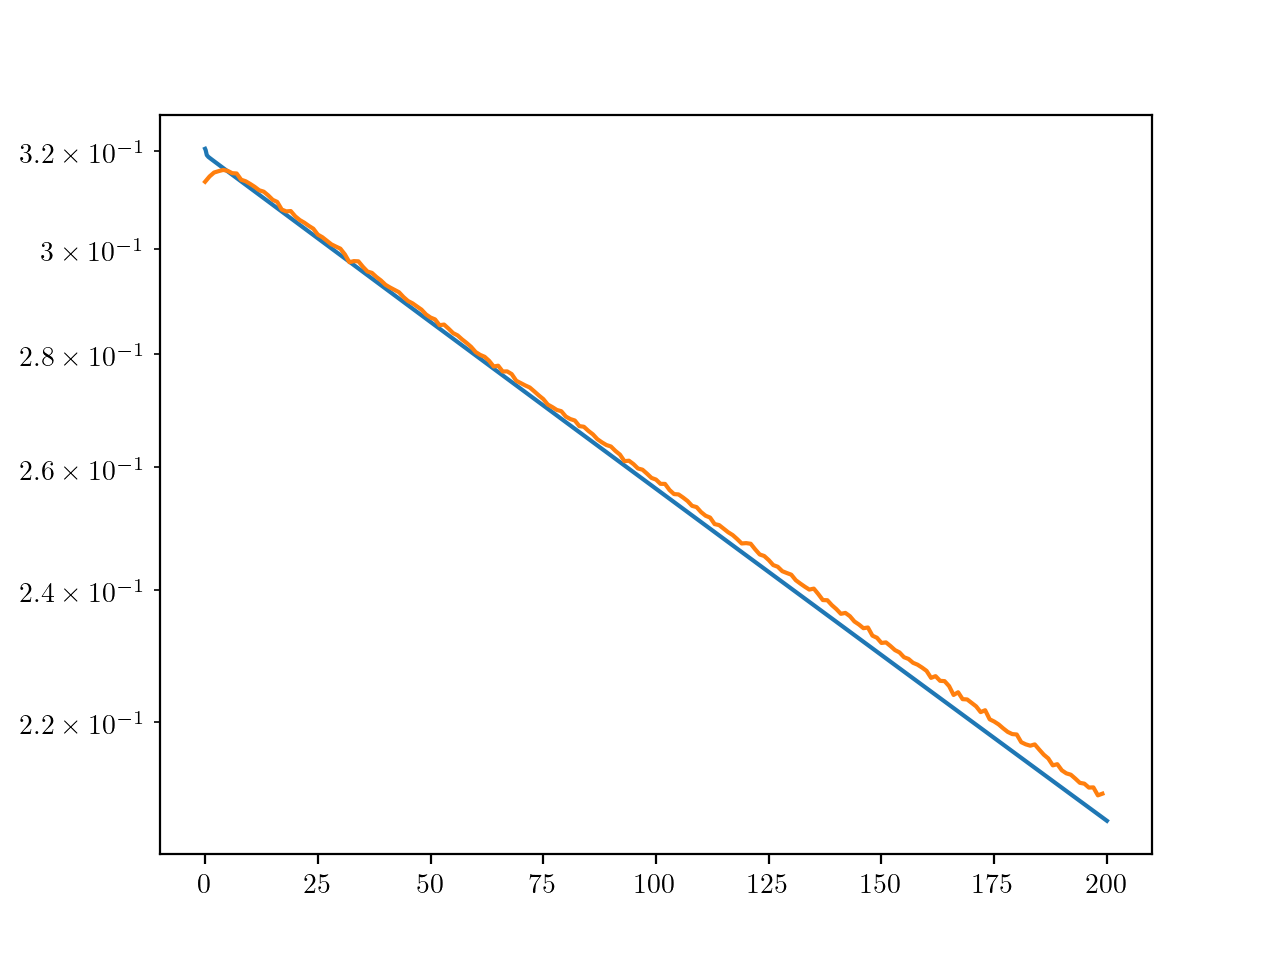

In [6]:
Nqp=nqp_to_Nqp(Q_list_Al,x_centers)

thetas = Nqp_to_theta(Nqp,dthetadN,Q,f0,times)

plt.figure()
plt.semilogy(times,thetas,label='simulation')
plt.semilogy(t_range,phase,label='measurement')

# 'fit' of eta_pb
factor = np.max(phase)/np.max(thetas)
print('eta_pb = ', eta_pb*factor)

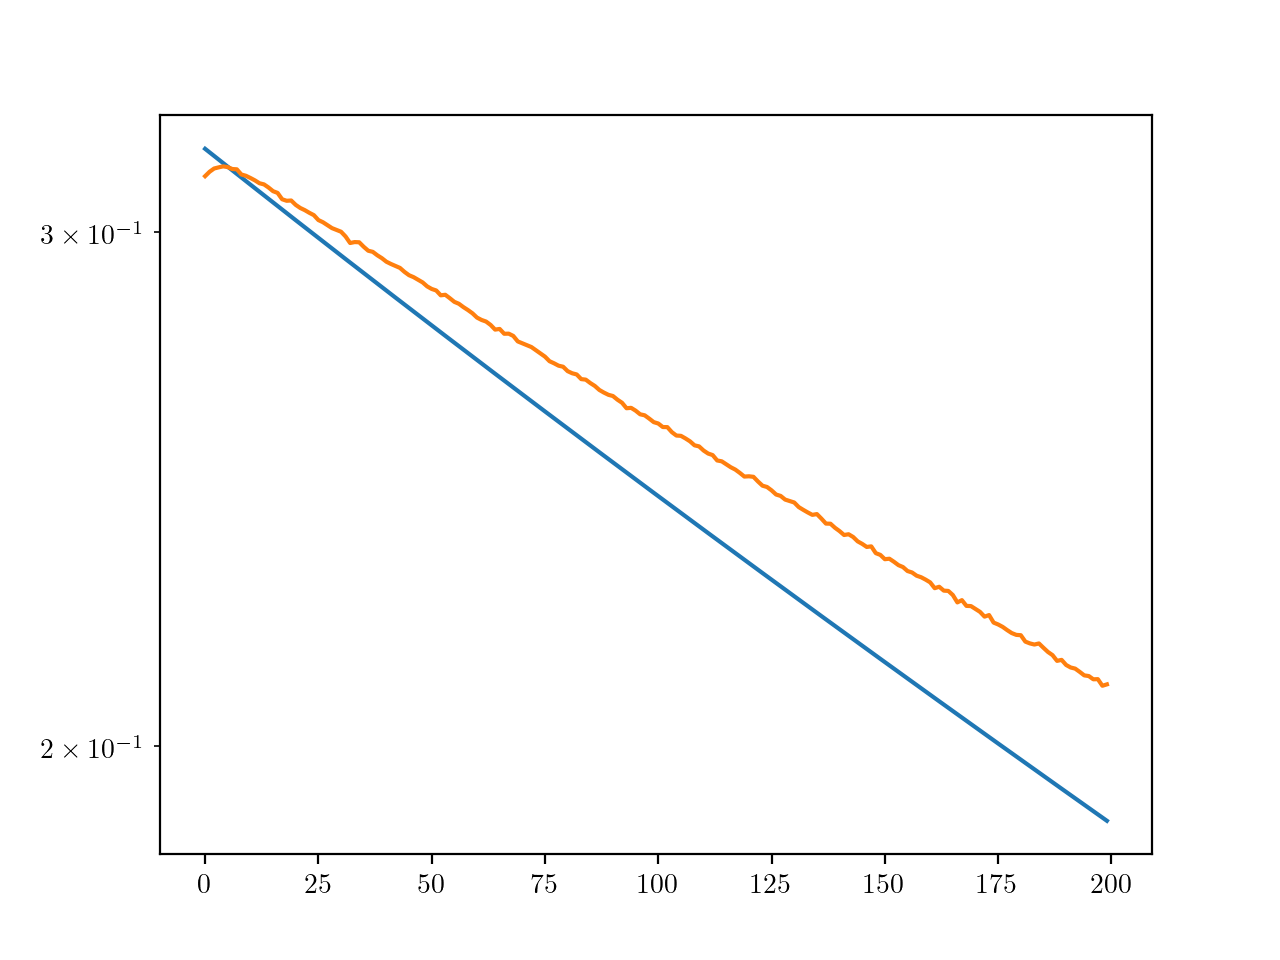

In [7]:
# Theory: thomas' 1/t oplossing

def decay(A,R,Q0,t):
  return 2*Q0/((2*Q0/A+1)*np.exp(2*Q0*R*t)-1)

t_range = np.arange(len(phase))
Qs,Ts =np.meshgrid(Q_init,t_range)

theory = decay(Qs,R,Q0,Ts)


Nqp=nqp_to_Nqp(theory,x_centers)

thetas = Nqp_to_theta(Nqp,dthetadN,Q,f0,t_range)

plt.figure()
plt.semilogy(t_range,thetas,label='simulation')
plt.semilogy(t_range,phase,label='measurement')
plt.show()